In [11]:
import sys
import os

# Adds the parent directory to the system path
sys.path.append(os.path.abspath("..")) 

from src.data.sentiment import FearGreedIndex


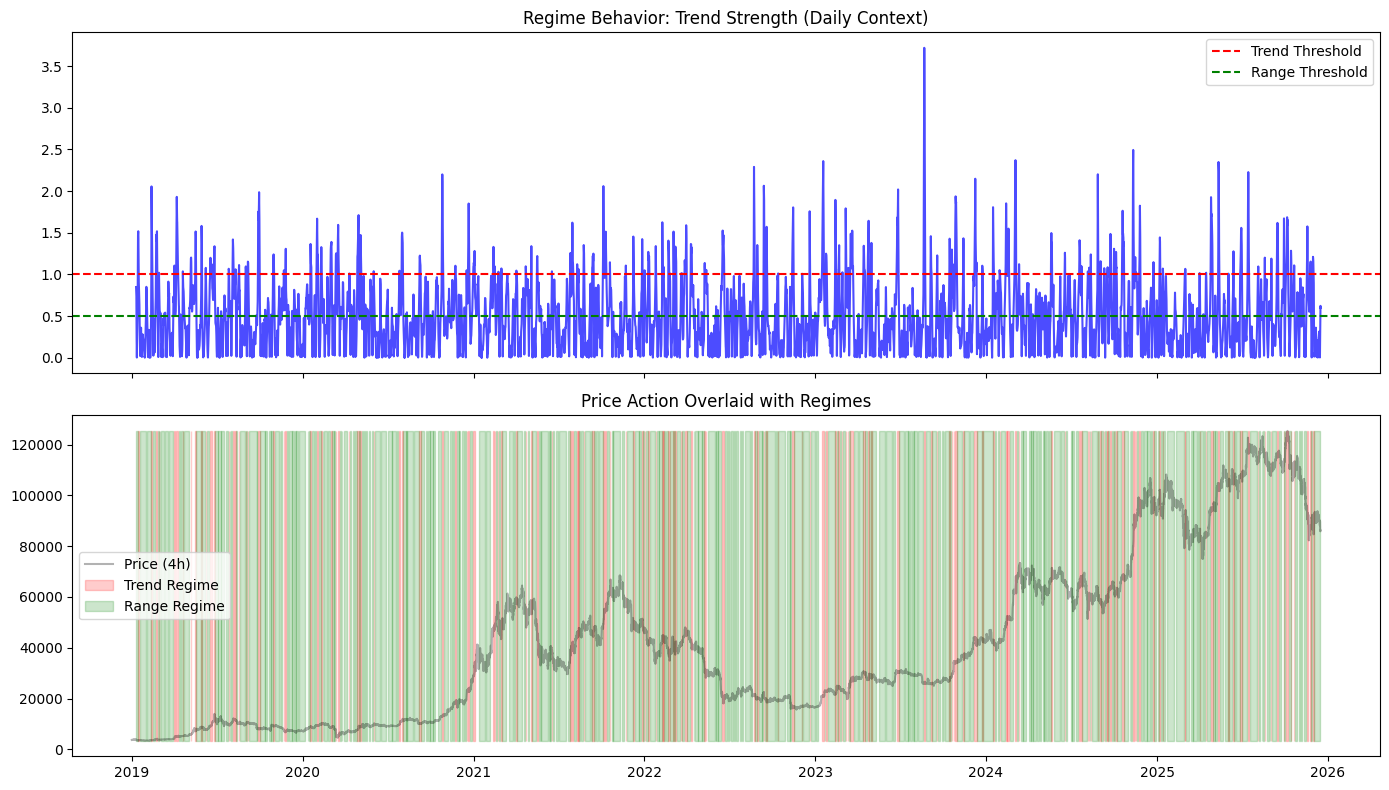

Updated btc_usdt_features.csv with 'trend_strength' and 'regime' columns.

Regime Counts:
regime
RANGE        8935
UNCERTAIN    4555
TREND        1699
UNKNOWN        55
Name: count, dtype: int64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the features file generated by your technical.py
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# 2. Calculate Daily ATR for normalization
# Note: We use D_high, D_low, D_close to ensure no lookahead bias
def calculate_daily_atr(df, window=14):
    tr1 = df["D_high"] - df["D_low"]
    tr2 = (df["D_high"] - df["D_close"].shift()).abs()
    tr3 = (df["D_low"] - df["D_close"].shift()).abs()
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range.rolling(window=window).mean()

df["atr_D"] = calculate_daily_atr(df)

# 3. Calculate Trend Strength Proxy (Daily SMA Distance / Daily ATR)
# This identifies if the "Big Trend" is moving or ranging
df["trend_strength"] = (
    (df["sma_20_D"] - df["sma_50_D"]).abs() / df["atr_D"]
)

# 4. Label Regimes based on thresholds
def label_regime(ts):
    if pd.isna(ts): return "UNKNOWN"
    if ts > 1.0: return "TREND"
    elif ts < 0.5: return "RANGE"
    else: return "UNCERTAIN"

df["regime"] = df["trend_strength"].apply(label_regime)

# 5. Visualize Results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Trend Strength
ax1.plot(df.index, df["trend_strength"], color='blue', alpha=0.7)
ax1.axhline(y=1.0, color='red', linestyle='--', label="Trend Threshold")
ax1.axhline(y=0.5, color='green', linestyle='--', label="Range Threshold")
ax1.set_title("Regime Behavior: Trend Strength (Daily Context)")
ax1.legend()

# Plot 2: Close Price with Regime Highlights
ax2.plot(df.index, df["close"], color='black', alpha=0.3, label="Price (4h)")
# Highlight "TREND" periods in light red
ax2.fill_between(df.index, df["close"].min(), df["close"].max(), 
                 where=(df["regime"] == "TREND"), color='red', alpha=0.2, label="Trend Regime")
# Highlight "RANGE" periods in light green
ax2.fill_between(df.index, df["close"].min(), df["close"].max(), 
                 where=(df["regime"] == "RANGE"), color='green', alpha=0.2, label="Range Regime")
ax2.set_title("Price Action Overlaid with Regimes")
ax2.legend()

plt.tight_layout()
plt.show()

# 6. Save updated features
df.to_csv("../data/btc_usdt_features.csv")
print("Updated btc_usdt_features.csv with 'trend_strength' and 'regime' columns.")
print("\nRegime Counts:")
print(df["regime"].value_counts())


In [2]:
# 1. Calculate the BB Width
df["bb_width_D"] = (df["bb_upper_D"] - df["bb_lower_D"]) / df["bb_mid_D"]

# 2. PRE-CALCULATE the 20th percentile threshold (the "Squeeze" level)
# This creates a column where each row knows what the 'squeeze' level was at that time
df["squeeze_threshold"] = df["bb_width_D"].rolling(100).quantile(0.2)

def identify_refined_regime(row):
    # 1. Trend Strength
    is_trending = row["trend_strength"] > 1.0
    
    # 2. Bollinger Position (%B)
    bb_range = row["bb_upper_4h"] - row["bb_lower_4h"]
    b_percent = (row["close"] - row["bb_lower_4h"]) / bb_range if bb_range != 0 else 0.5
    
    if is_trending:
        if b_percent > 0.8: return "TREND_BULLISH_EXPANSION"
        if b_percent < 0.2: return "TREND_BEARISH_EXPANSION"
        return "TREND_RETRACEMENT"
    else:
        # 3. Compare the row's width to its specific threshold
        # We use row["squeeze_threshold"] which we calculated above
        if row["bb_width_D"] < row["squeeze_threshold"]:
            return "RANGE_SQUEEZE"
        return "RANGE_CHOP"

# Now the apply will work because it's comparing two single numbers
df["refined_regime"] = df.apply(identify_refined_regime, axis=1)

# Preview
print(df["refined_regime"].value_counts())


refined_regime
RANGE_CHOP                 10712
RANGE_SQUEEZE               2833
TREND_RETRACEMENT            964
TREND_BULLISH_EXPANSION      437
TREND_BEARISH_EXPANSION      298
Name: count, dtype: int64


In [3]:
# 1. Final calculations
df["bb_width_D"] = (df["bb_upper_D"] - df["bb_lower_D"]) / df["bb_mid_D"]
df["squeeze_threshold"] = df["bb_width_D"].rolling(100).quantile(0.2)
df["refined_regime"] = df.apply(identify_refined_regime, axis=1)

# 2. Save the updated dataframe
df.to_csv("../data/btc_usdt_features.csv")
print("Features file updated successfully.")


Features file updated successfully.


### Build the Trend Signal(sma crossover)

Average 4h Return (%) per Regime for Trend Strategy:
refined_regime
TREND_BULLISH_EXPANSION    0.100270
TREND_RETRACEMENT          0.043731
RANGE_CHOP                 0.018556
RANGE_SQUEEZE             -0.006440
TREND_BEARISH_EXPANSION   -0.077877
Name: trend_strategy_ret, dtype: float64


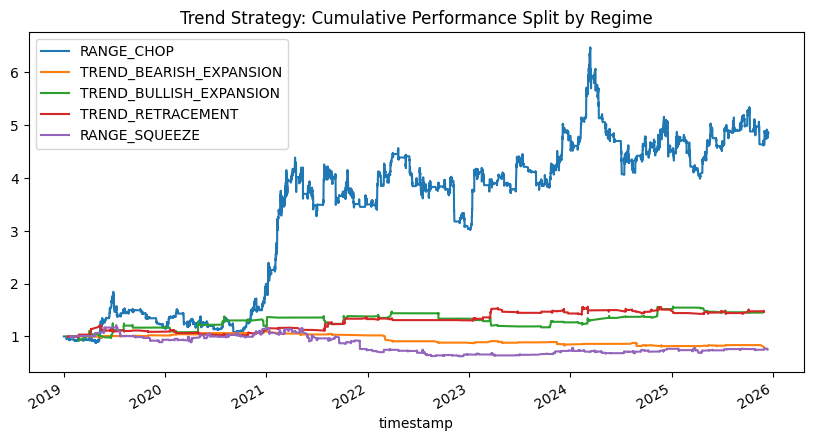

In [4]:
#Build the Trend Signal
import pandas as pd

# Load the comprehensive features file
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# --- 2. Build the Trend Signal (Daily Context) ---
# Logic: If Daily Fast SMA > Daily Slow SMA, we have a Bullish Trend Signal
df["trend_signal"] = 0
df.loc[df["sma_20_D"] > df["sma_50_D"], "trend_signal"] = 1

# --- 3. Compute 4h Strategy Returns ---
# We calculate the pct_change of the current 4h close.
# Then we shift(-1) to align "Today's Signal" with "Next Bar's Return"
df["next_4h_return"] = df["close"].pct_change().shift(-1)

# Strategy return is (Signal * Next Return)
df["trend_strategy_ret"] = df["trend_signal"] * df["next_4h_return"]

#Performance by Regime
# --- 4. Trend Strategy Performance by Regime ---
# We group by 'refined_regime' to see where the SMA Crossover actually makes money
trend_perf = (
    df.groupby("refined_regime")["trend_strategy_ret"]
    .mean() * 100  # Convert to percentage for readability
)

print("Average 4h Return (%) per Regime for Trend Strategy:")
print(trend_perf.sort_values(ascending=False))

# Visualization of cumulative performance per regime
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for regime in df["refined_regime"].unique():
    subset = df[df["refined_regime"] == regime].copy()
    # Cumulative returns for just this regime
    (1 + subset["trend_strategy_ret"].fillna(0)).cumprod().plot(label=regime)

plt.title("Trend Strategy: Cumulative Performance Split by Regime")
plt.legend()
plt.show()


Final Buy and Hold Cumulative Return: 23.32
Final SMA Trend Strategy Return: 6.09


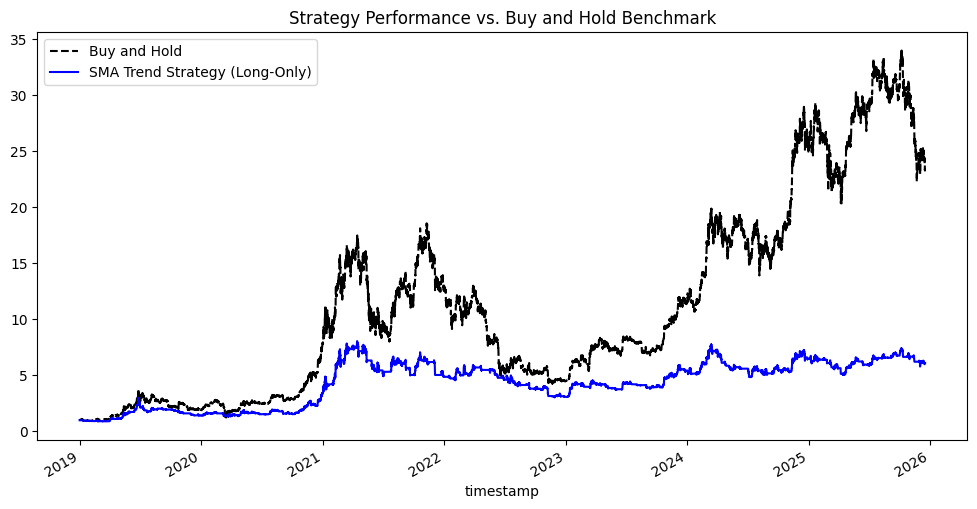

In [5]:
# Compare Strategy vs. Buy and Hold Benchmark
import pandas as pd
import matplotlib.pyplot as plt

# Load your feature-rich data
# Ensure the path matches where your file is located
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# --- 1. Calculate SMA Trend Strategy Returns (Re-integrated) ---
# This part must run first to create the 'trend_strategy_ret' column
df["trend_signal"] = 0
df.loc[df["sma_20_D"] > df["sma_50_D"], "trend_signal"] = 1
df["next_4h_return"] = df["close"].pct_change().shift(-1)
df["trend_strategy_ret"] = df["trend_signal"] * df["next_4h_return"]


# --- 2. Calculate Buy and Hold Returns (Benchmark) ---
df["returns_buy_and_hold"] = df["close"].pct_change()

# --- 3. Calculate Cumulative Performance for Plotting ---

# SMA Strategy Cumulative Returns
df["sma_cumulative_returns"] = (1 + df["trend_strategy_ret"].fillna(0)).cumprod()

# Buy and Hold Cumulative Returns
df["cumulative_buy_and_hold"] = (1 + df["returns_buy_and_hold"].fillna(0)).cumprod()


# --- 4. Print Final Results and Plot ---

final_hold_return = df["cumulative_buy_and_hold"].iloc[-1]
final_sma_return = df["sma_cumulative_returns"].iloc[-1]

print(f"Final Buy and Hold Cumulative Return: {final_hold_return:.2f}")
print(f"Final SMA Trend Strategy Return: {final_sma_return:.2f}")

plt.figure(figsize=(12, 6))
df["cumulative_buy_and_hold"].plot(label="Buy and Hold", color='black', linestyle='--')
df["sma_cumulative_returns"].plot(label="SMA Trend Strategy (Long-Only)", color='blue')

plt.title("Strategy Performance vs. Buy and Hold Benchmark")
plt.legend()
plt.show()


Final Buy and Hold Cumulative Return: 23.32
Final SMA Trend Strategy (with 10% SL) Return: 14.24


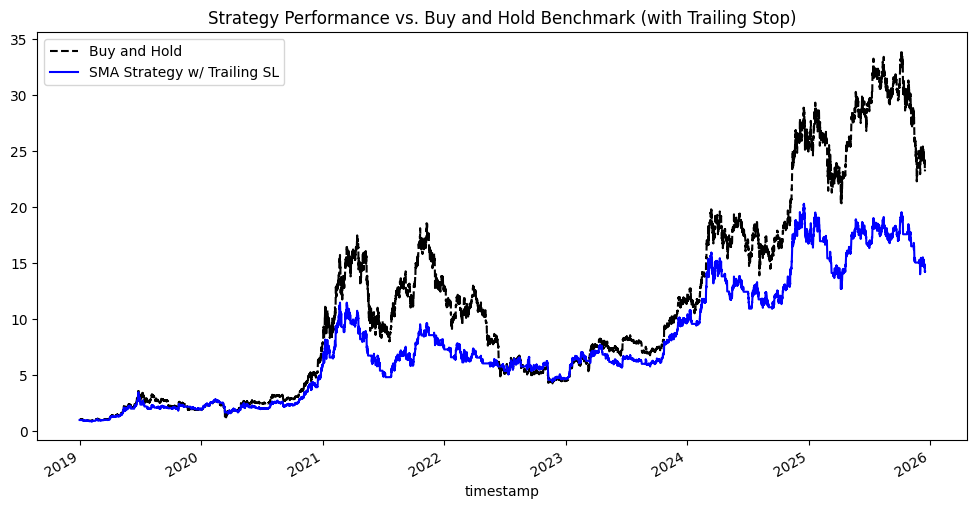

In [6]:
#Implementing a trailing stop loss can help you stay in profitable trades longer 
# by only exiting when the price reverses by a predefined amount from its peak.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your feature-rich data
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# --- 1. Define Settings ---
STOP_LOSS_PCT = 0.10 # 10% trailing stop loss

# --- 2. Build the Raw Trend Signal (Daily Context) ---
df["trend_signal"] = np.where(df["sma_20_D"] > df["sma_50_D"], 1.0, 0.0)

# --- 3. Implement Trailing Stop Logic ---

# Initialize a column for the actual position held (0 = flat, 1 = long)
df["sma_position"] = 0.0
# Track the peak price reached while in a long position
peak_price = 0.0
position = 0.0

# Iterate through the DataFrame to apply stop loss logic dynamically
for i in range(1, len(df)):
    current_close = df["close"].iloc[i]
    
    if position == 0.0:
        # Check for entry signal
        if df["trend_signal"].iloc[i] == 1.0:
            position = 1.0
            peak_price = current_close
    
    elif position == 1.0:
        # Update peak price if a new high is reached
        if current_close > peak_price:
            peak_price = current_close
        
        # Check for exit condition (price drops 10% from peak)
        if current_close < peak_price * (1 - STOP_LOSS_PCT):
            position = 0.0
            peak_price = 0.0 # Reset peak tracking
            
    df.iloc[i, df.columns.get_loc("sma_position")] = position

# --- 4. Calculate Strategy Returns with new position column ---

df["sma_strategy_ret"] = df["close"].pct_change() * df["sma_position"].shift(1)
df["sma_cumulative_returns"] = (1 + df["sma_strategy_ret"].fillna(0)).cumprod()

# --- 5. Plot Comparison (Buy and Hold for context) ---

df["returns_buy_and_hold"] = df["close"].pct_change()
df["cumulative_buy_and_hold"] = (1 + df["returns_buy_and_hold"].fillna(0)).cumprod()

print(f"Final Buy and Hold Cumulative Return: {df['cumulative_buy_and_hold'].iloc[-1]:.2f}")
print(f"Final SMA Trend Strategy (with 10% SL) Return: {df['sma_cumulative_returns'].iloc[-1]:.2f}")


plt.figure(figsize=(12, 6))
df["cumulative_buy_and_hold"].plot(label="Buy and Hold", color='black', linestyle='--')
df["sma_cumulative_returns"].plot(label="SMA Strategy w/ Trailing SL", color='blue')
plt.title("Strategy Performance vs. Buy and Hold Benchmark (with Trailing Stop)")
plt.legend()
plt.show()


### Build a Simple Mean-Reversion Signal(RSI)

Average 4h Return (%) per Regime for RSI Mean-Reversion Strategy:
refined_regime
RANGE_CHOP                 0.010204
RANGE_SQUEEZE              0.001259
TREND_BULLISH_EXPANSION    0.001061
TREND_RETRACEMENT         -0.008877
TREND_BEARISH_EXPANSION   -0.094052
Name: mr_strategy_ret, dtype: float64


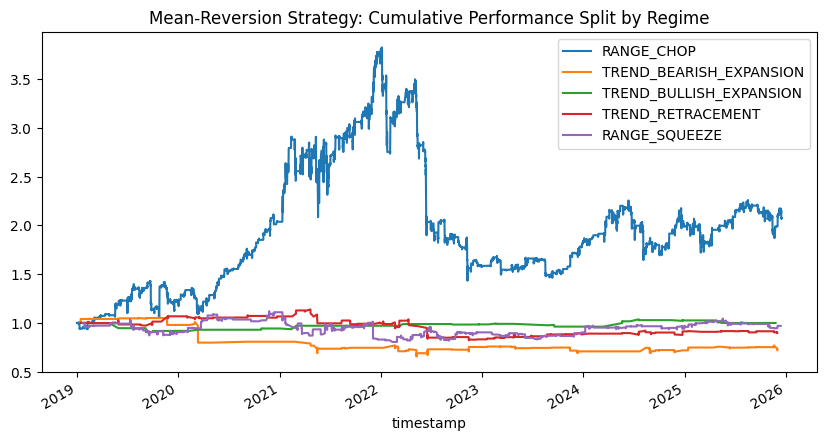

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the comprehensive features file
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# --- 1. Build the Mean-Reversion Signal (Daily Context) ---
# Logic: If Daily RSI < 30 (oversold), generate a buy signal (1).
# We assume this is a long-only mean-reversion strategy
df["mr_signal"] = 0
df.loc[df["rsi_D"] < 30, "mr_signal"] = 1

# --- 2. Compute 4h Strategy Returns ---
# We use the next 4h return, shifting back the signal for non-lookahead bias
df["next_4h_return"] = df["close"].pct_change().shift(-1)

# Strategy return is (Signal * Next Return)
# Only capture returns when the signal is active (1)
df["mr_strategy_ret"] = df["mr_signal"] * df["next_4h_return"]

# --- 3. Mean-Reversion Performance by Regime ---
# Group by 'refined_regime' to see where the RSI strategy works best
mr_perf = (
    df.groupby("refined_regime")["mr_strategy_ret"]
    .mean() * 100  # Convert to percentage for readability
)

print("Average 4h Return (%) per Regime for RSI Mean-Reversion Strategy:")
print(mr_perf.sort_values(ascending=False))


# --- 4. Visualization of cumulative performance per regime ---
plt.figure(figsize=(10, 5))

# Filter out NA values which appear at the start of the data due to indicator calculation
plot_df = df.dropna(subset=["mr_strategy_ret", "refined_regime"])

for regime in plot_df["refined_regime"].unique():
    subset = plot_df[plot_df["refined_regime"] == regime].copy()
    # Cumulative returns for just this regime
    (1 + subset["mr_strategy_ret"]).cumprod().plot(label=regime)

plt.title("Mean-Reversion Strategy: Cumulative Performance Split by Regime")
plt.legend()
plt.show()


### Bollinger Band Mean-Reversion Strategy


Bollinger Band Strategy Cumulative Returns:
1.6060660711572254
Average 4h Return (%) per Regime for Bollinger Band Strategy:
refined_regime
TREND_BULLISH_EXPANSION    0.160488
TREND_RETRACEMENT          0.124581
RANGE_CHOP                 0.015486
RANGE_SQUEEZE             -0.011421
TREND_BEARISH_EXPANSION   -0.682066
Name: bb_strategy_ret, dtype: float64


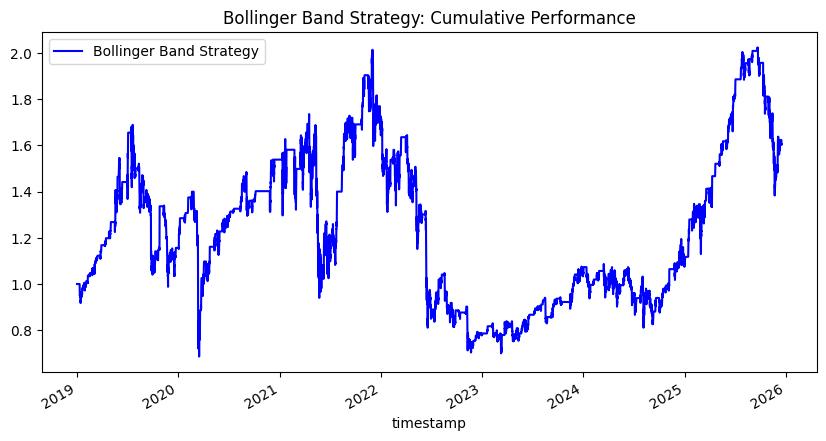

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Added import for plotting

# Load your feature-rich data
# Ensure the path is correct for your environment
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# --- 1. Define the Bollinger Band Strategy Signals ---

# Buy signal (Long entry) occurs when the close price touches or falls below the lower band
df["bb_long_signal"] = (df["close"] <= df["bb_lower_4h"]) & (df["close"].shift(1) > df["bb_lower_4h"].shift(1))

# Sell signal (Long exit) occurs when the close price touches or rises above the upper band
df["bb_sell_signal"] = (df["close"] >= df["bb_upper_4h"]) & (df["close"].shift(1) < df["bb_upper_4h"].shift(1))

# Convert signals to a single 'position' column for simple backtesting
# Use forward fill (ffill) to maintain position until an exit signal is hit
df["bb_position"] = np.nan
df.loc[df["bb_long_signal"] == True, "bb_position"] = 1.0    # Long
df.loc[df["bb_sell_signal"] == True, "bb_position"] = 0.0    # Exit/Flat

# Fill the position forward
df["bb_position"] = df["bb_position"].ffill().fillna(0.0) # Start as flat if no initial signal

# --- 2. Calculate Simple Returns for this Strategy ---

# Calculate the price change
df["returns"] = df["close"].pct_change()

# Calculate the strategy's returns: return only when in a 'long' position (1)
df["bb_strategy_returns"] = df["returns"] * df["bb_position"].shift(1)

# Calculate cumulative returns
df["bb_cumulative_returns"] = (1 + df["bb_strategy_returns"].fillna(0.0)).cumprod()


# --- 3. Preview Results and Attribution ---

print("\nBollinger Band Strategy Cumulative Returns:")
print(df["bb_cumulative_returns"].iloc[-1])

# If you have the refined_regime column calculated:
# print("\nMean returns by Regime:")
# print(df.groupby("refined_regime")["bb_strategy_returns"].mean() * 100)

df["bb_strategy_ret"] = df["close"].pct_change() * df["bb_position"].shift(1)


bb_perf = (
    df.groupby("refined_regime")["bb_strategy_ret"]
    .mean() * 100  # Convert to percentage for readability
)

print("Average 4h Return (%) per Regime for Bollinger Band Strategy:")
print(bb_perf.sort_values(ascending=False))
# --- 4. Visualization of cumulative performance ---

plt.figure(figsize=(10, 5))
# Use .dropna() to ensure clean plotting start
df["bb_cumulative_returns"].dropna().plot(label="Bollinger Band Strategy", color='blue') 

plt.title("Bollinger Band Strategy: Cumulative Performance")
plt.legend()
plt.show()

# OPTIONAL: Save the new data
# df.to_csv("data/btc_usdt_features.csv")


Average 4h Return (%) per Regime for Bollinger Band Strategy:
refined_regime
TREND_BULLISH_EXPANSION    0.160488
TREND_RETRACEMENT          0.124581
RANGE_CHOP                 0.015486
RANGE_SQUEEZE             -0.011421
TREND_BEARISH_EXPANSION   -0.682066
Name: bb_strategy_ret, dtype: float64


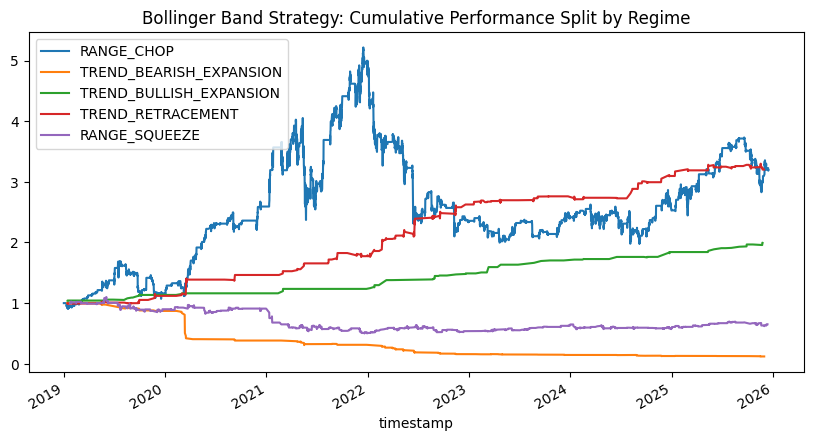

Overall Bollinger Band Strategy Cumulative Return: 1.61


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the comprehensive features file
df = pd.read_csv("../data/btc_usdt_features.csv", index_col=0, parse_dates=True)

# --- 1. Define Bollinger Band Strategy Signals (4h Timeframe) ---

# Buy signal (enter long position): price touches or falls below the lower band
df["bb_long_signal"] = df["close"] <= df["bb_lower_4h"]

# Sell signal (exit long position): price touches or rises above the upper band
df["bb_sell_signal"] = df["close"] >= df["bb_upper_4h"]

# Convert signals to a single 'position' column
# We are long (1) when the buy signal is True, and flat/exit (0) when the sell signal is True
df["bb_position"] = np.nan
df.loc[df["bb_long_signal"] == True, "bb_position"] = 1.0
df.loc[df["bb_sell_signal"] == True, "bb_position"] = 0.0

# Use forward fill (ffill) to maintain the position until the next signal is hit
df["bb_position"] = df["bb_position"].ffill().fillna(0.0) # Start as flat if no initial signal

# --- 2. Compute 4h Strategy Returns ---

df["bb_strategy_ret"] = df["close"].pct_change() * df["bb_position"].shift(1)

# --- 3. Performance by Regime ---

bb_perf = (
    df.groupby("refined_regime")["bb_strategy_ret"]
    .mean() * 100  # Convert to percentage for readability
)

print("Average 4h Return (%) per Regime for Bollinger Band Strategy:")
print(bb_perf.sort_values(ascending=False))


# --- 4. Visualization of cumulative performance ---

plt.figure(figsize=(10, 5))
plot_df = df.dropna(subset=["bb_strategy_ret", "refined_regime"])

for regime in plot_df["refined_regime"].unique():
    subset = plot_df[plot_df["refined_regime"] == regime].copy()
    (1 + subset["bb_strategy_ret"]).cumprod().plot(label=regime)

plt.title("Bollinger Band Strategy: Cumulative Performance Split by Regime")
plt.legend()
plt.show()

# --- 5. Overall Cumulative Return (Benchmark Comparison) ---
df["bb_cumulative_returns"] = (1 + df["bb_strategy_ret"].fillna(0.0)).cumprod()
print(f"Overall Bollinger Band Strategy Cumulative Return: {df['bb_cumulative_returns'].iloc[-1]:.2f}")


### Sentiment Correlation & Filtering Logic

In [12]:
from src.data.sentiment import FearGreedIndex

fng = FearGreedIndex()
sentiment = pd.read_csv(
    "../data/fear_greed_index.csv",
    index_col=0,
    parse_dates=True,
)

sentiment = sentiment.sort_index()
sentiment.head()


,value,value_classification,time_until_update,sentiment_norm
timestamp,,,,
2018-02-01 00:00:00+00:00,30.0,Fear,NaN,0.30
2018-02-02 00:00:00+00:00,15.0,Extreme Fear,NaN,0.15
2018-02-03 00:00:00+00:00,40.0,Fear,NaN,0.40
2018-02-04 00:00:00+00:00,24.0,Extreme Fear,NaN,0.24
2018-02-05 00:00:00+00:00,11.0,Extreme Fear,NaN,0.11


In [13]:
import pandas as pd

# 1. Load the data
# Ensure 'timestamp' is parsed as a datetime and set as the index
df_features = pd.read_csv("../data/btc_usdt_features.csv", index_col='timestamp', parse_dates=True)
df_sent = pd.read_csv("../data/fear_greed_index.csv", index_col=0, parse_dates=True)

# 2. Sort both by index (required for merge_asof)
df_features = df_features.sort_index()
df_sent = df_sent.sort_index()

# 3. Align daily sentiment to the features data
# 'backward' ensures each 4h/1d candle uses the most recent sentiment value available
df_final = pd.merge_asof(
    df_features,
    df_sent[["sentiment_norm"]],
    left_index=True,
    right_index=True,
    direction="backward"
)

# 4. Save the fully aligned dataset
df_final.to_csv("../data/btc_usdt_features.csv")


In [14]:
#check alignment

In [15]:
df_final[["close", "sentiment_norm"]].dropna().iloc[-10:]

,close,sentiment_norm
timestamp,,
2025-12-14 20:00:00+00:00,88172.17,0.21
2025-12-15 00:00:00+00:00,89282.60,0.16
2025-12-15 04:00:00+00:00,89753.42,0.16
2025-12-15 08:00:00+00:00,89641.28,0.16
2025-12-15 12:00:00+00:00,87033.22,0.16
2025-12-15 16:00:00+00:00,86149.96,0.16
2025-12-15 20:00:00+00:00,86432.08,0.16
2025-12-16 00:00:00+00:00,85875.92,0.11
2025-12-16 04:00:00+00:00,86021.51,0.11


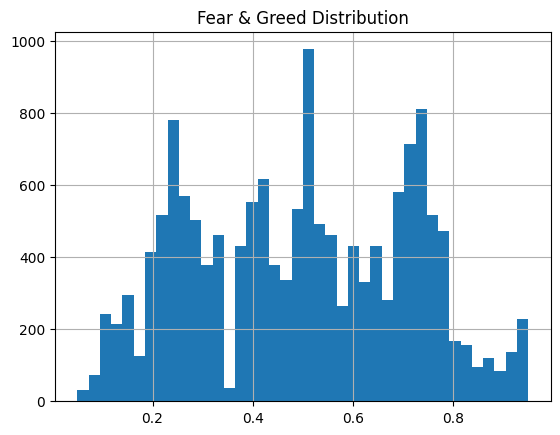

In [16]:
#Sentiment Distribution
df_final["sentiment_norm"].hist(bins=40)
plt.title("Fear & Greed Distribution")
plt.show()


In [17]:
#Returns vs Sentiment Buckets
df_final["next_return"] = df_final["close"].pct_change().shift(-1)

df_final["sent_bucket"] = pd.cut(
    df_final["sentiment_norm"],
    bins=[0, 0.25, 0.45, 0.55, 0.75, 1.0],
    labels=["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"],
)

df_final.groupby("sent_bucket")["next_return"].mean()


/var/folders/tp/yqpy0mgx4h33s134ys5_bylc0000gn/T/ipykernel_11282/2649126342.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby("sent_bucket")["next_return"].mean()


sent_bucket
Extreme Fear     0.000387
Fear            -0.000134
Neutral          0.000332
Greed            0.000501
Extreme Greed    0.000546
Name: next_return, dtype: float64

In [19]:
#Trend Strategy + Sentiment
df_final["trend_signal"] = np.where(df_final["sma_20_D"] > df_final["sma_50_D"], 1.0, 0.0)

trend_sent_perf = (
    df_final[df_final["trend_signal"] == 1]
    .groupby("sent_bucket")["next_return"]
    .mean()
)

trend_sent_perf


/var/folders/tp/yqpy0mgx4h33s134ys5_bylc0000gn/T/ipykernel_11282/3836969495.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sent_bucket")["next_return"]


sent_bucket
Extreme Fear     0.000286
Fear            -0.000381
Neutral          0.000431
Greed            0.000454
Extreme Greed    0.000631
Name: next_return, dtype: float64

In [20]:
#Mean-Reversion + Sentiment
df_final["mr_signal"] = 0
df_final.loc[df_final["rsi_D"] < 30, "mr_signal"] = 1

mr_sent_perf = (
    df_final[df_final["mr_signal"] == 1]
    .groupby("sent_bucket")["next_return"]
    .mean()
)

mr_sent_perf


/var/folders/tp/yqpy0mgx4h33s134ys5_bylc0000gn/T/ipykernel_11282/3534327459.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("sent_bucket")["next_return"]


sent_bucket
Extreme Fear     0.000176
Fear            -0.000119
Neutral         -0.000003
Greed            0.000429
Extreme Greed    0.000882
Name: next_return, dtype: float64

In [22]:
#bollinger Bands + Sentiment
import pandas as pd
import numpy as np

# ASSUMPTION: We are continuing with the 'df_final' DataFrame from prior steps, 
# which has 'sentiment_norm', 'sent_bucket', 'close', 'bb_upper_4h', 'bb_lower_4h'.

# --- 1. Ensure BB Position is calculated in df_final ---

# Buy signal: price crosses below lower band
df_final["bb_long_signal"] = (df_final["close"] <= df_final["bb_lower_4h"]) & (df_final["close"].shift(1) > df_final["bb_lower_4h"].shift(1))

# Sell signal: price crosses above upper band
df_final["bb_sell_signal"] = (df_final["close"] >= df_final["bb_upper_4h"]) & (df_final["close"].shift(1) < df_final["bb_upper_4h"].shift(1))

# Convert signals to a single 'position' column (1.0 for Long, 0.0 for Exit)
df_final["bb_position"] = np.nan
df_final.loc[df_final["bb_long_signal"] == True, "bb_position"] = 1.0
df_final.loc[df_final["bb_sell_signal"] == True, "bb_position"] = 0.0
df_final["bb_position"] = df_final["bb_position"].ffill().fillna(0.0) # Start flat

# --- 2. Calculate Strategy Returns (only when in position) ---

df_final["returns"] = df_final["close"].pct_change()

# The return of the strategy = actual return IF we are in a long position (1), else 0
# We use .shift(1) to prevent lookahead bias (use previous period's position to trade current period's return)
df_final["bb_strategy_returns"] = df_final["returns"] * df_final["bb_position"].shift(1)


# --- 3. Group Strategy Returns by Sentiment Bucket ---

bb_sent_perf = (
    df_final.groupby("sent_bucket")["bb_strategy_returns"]
    .mean() * 100  # Convert to percentage for readability
)

print("Average 4h Return (%) for Bollinger Band Strategy per Sentiment Bucket:")
print(bb_sent_perf.sort_values(ascending=False))


Average 4h Return (%) for Bollinger Band Strategy per Sentiment Bucket:
sent_bucket
Extreme Fear     0.041372
Greed            0.016422
Neutral          0.004817
Extreme Greed   -0.006042
Fear            -0.016499
Name: bb_strategy_returns, dtype: float64


/var/folders/tp/yqpy0mgx4h33s134ys5_bylc0000gn/T/ipykernel_11282/3899322513.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby("sent_bucket")["bb_strategy_returns"]


In [24]:
#1d bollinger Bands + Sentiment
# --- Daily Bollinger Band Strategy ---

# Buy signal: price crosses below lower band
df_final["bb_long_signal_D"] = (df_final["D_close"] <= df_final["bb_lower_D"]) & (
    df_final["D_close"].shift(1) > df_final["bb_lower_D"].shift(1)
)

# Sell signal: price crosses above upper band
df_final["bb_sell_signal_D"] = (df_final["D_close"] >= df_final["bb_upper_D"]) & (
    df_final["D_close"].shift(1) < df_final["bb_upper_D"].shift(1)
)

# Position tracking
df_final["bb_position_D"] = np.nan
df_final.loc[df_final["bb_long_signal_D"], "bb_position_D"] = 1.0
df_final.loc[df_final["bb_sell_signal_D"], "bb_position_D"] = 0.0
df_final["bb_position_D"] = df_final["bb_position_D"].ffill().fillna(0.0)

# Strategy returns (daily)
df_final["returns_D"] = df_final["D_close"].pct_change()
df_final["bb_strategy_returns_D"] = df_final["returns_D"] * df_final["bb_position_D"].shift(1)

# Group by sentiment bucket
bb_sent_perf_D = (
    df_final.groupby("sent_bucket")["bb_strategy_returns_D"]
    .mean() * 100
)

print("Average 1D Return (%) for Bollinger Band Strategy per Sentiment Bucket:")
print(bb_sent_perf_D.sort_values(ascending=False))


Average 1D Return (%) for Bollinger Band Strategy per Sentiment Bucket:
sent_bucket
Extreme Greed    0.059073
Greed            0.044425
Neutral          0.038742
Fear             0.021219
Extreme Fear    -0.103051
Name: bb_strategy_returns_D, dtype: float64


/var/folders/tp/yqpy0mgx4h33s134ys5_bylc0000gn/T/ipykernel_11282/985082585.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final.groupby("sent_bucket")["bb_strategy_returns_D"]


### Sentiment → Regime Mapping
### Extreme Greed (sentiment_norm > 0.75)

TREND → enable (continuation rallies are strongest here)

RANGE → enable (overshoots revert reliably in greed)

BOLLINGER (1D) → enable (daily greed rallies sustain)

### Greed (0.5–0.75)

TREND → enable (optimism supports continuation)

RANGE → enable (mean‑reversion works well in moderate optimism)

BOLLINGER (1D) → enable (positive returns observed)

### Neutral (0.25–0.5)

UNCERTAIN → reduce risk or do nothing

Trend and mean‑reversion both weak; Bollinger flat.

### Fear (0.25–0.5, leaning lower)

RANGE → enable cautiously (short‑term overselling can revert)

TREND → block (fear breaks continuation)

BOLLINGER (1D) → allow cautiously (small positive returns)

### Extreme Fear (sentiment_norm < 0.25)

UNCERTAIN → block trades

TREND → block (panic breaks trends)

RANGE → block longs (daily panic overwhelms contrarian setups)

BOLLINGER (1D) → block longs (daily panic selling dominates)

### 🧠 Key Principles
TREND thrives in optimism (Greed/Extreme Greed).

RANGE (Mean‑Reversion) thrives in Greed, weak in Fear, fails in Extreme Fear.

BOLLINGER (1D) aligns with optimism, fails in Extreme Fear.

UNCERTAIN zones (Neutral, Extreme Fear) → safest to reduce risk or stay flat.